# 05f - Train Elastic Net Models (All LLMs)

**Purpose**: Train Elastic Net regression models for all 5 LLMs to learn the mapping from BGE embeddings to OCEAN scores with better regularization

**Why Elastic Net over Ridge?**
- Basic Ridge regression showed severe overfitting: train R² ≈ 0.999, test R² < 0
- Problem: 1024 features vs ~400 samples → dimension curse
- Elastic Net = L1 + L2 regularization:
  - L1 (Lasso): Feature selection, removes noise features
  - L2 (Ridge): Stability, prevents overfitting
- ElasticNetCV: Automatic hyperparameter tuning via 5-fold cross-validation

**Input Files**:
- bge_embeddings_500.npy - BGE embeddings (500x1024)
- ocean_ground_truth/[llm]_ocean_500.csv - OCEAN ground truth for each LLM

**Output Files** (per LLM):
- elasticnet_models_[llm].pkl - 5 Elastic Net models + Scaler
- 05f_elasticnet_training_report_[llm].json - Training report with feature importance

**Summary Output**:
- 05f_elasticnet_comparison.png - Performance comparison across LLMs
- 05f_ridge_vs_elasticnet.csv - Ridge vs Elastic Net comparison

**Estimated Time**: Approximately 10-15 minutes (5 LLMs x CV grid search)

## Step 1: Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import pickle
import os
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNetCV, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from datetime import datetime

print("Libraries loaded successfully")
print(f"Timestamp: {datetime.now()}")

Libraries loaded successfully
Timestamp: 2025-10-28 00:16:55.656443


## Step 2: Configuration

In [2]:
# LLM configurations
LLM_CONFIGS = {
    'llama': {
        'name': 'Llama-3.1-8B',
        'ocean_file': '../ocean_ground_truth/llama_3.1_8b_ocean_500.csv',
        'ridge_report': '../05f_ridge_training_report_llama.json'
    },
    'gpt': {
        'name': 'GPT-OSS-120B',
        'ocean_file': '../ocean_ground_truth/gpt_oss_120b_ocean_500.csv',
        'ridge_report': '../05f_ridge_training_report_gpt.json'
    },
    'gemma': {
        'name': 'Gemma-2-9B',
        'ocean_file': '../ocean_ground_truth/gemma_2_9b_ocean_500.csv',
        'ridge_report': '../05f_ridge_training_report_gemma.json'
    },
    'deepseek': {
        'name': 'DeepSeek-V3.1',
        'ocean_file': '../ocean_ground_truth/deepseek_v3.1_ocean_500.csv',
        'ridge_report': '../05f_ridge_training_report_deepseek.json'
    },
    'qwen': {
        'name': 'Qwen-2.5-72B',
        'ocean_file': '../ocean_ground_truth/qwen_2.5_72b_ocean_500.csv',
        'ridge_report': '../05f_ridge_training_report_qwen.json'
    }
}

# OCEAN dimensions
OCEAN_DIMS = ['openness', 'conscientiousness', 'extraversion', 'agreeableness', 'neuroticism']

# ElasticNetCV hyperparameters
ALPHAS = [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0]
L1_RATIOS = [0.1, 0.3, 0.5, 0.7, 0.9, 0.95, 0.99]
CV_FOLDS = 5

# Random seed for reproducibility
RANDOM_STATE = 42

print(f"Configuration loaded:")
print(f"  LLM models: {len(LLM_CONFIGS)}")
print(f"  OCEAN dimensions: {len(OCEAN_DIMS)}")
print(f"  Alpha grid: {len(ALPHAS)} values")
print(f"  L1 ratio grid: {len(L1_RATIOS)} values")
print(f"  Total CV combinations: {len(ALPHAS) * len(L1_RATIOS)} per dimension")
print(f"  CV folds: {CV_FOLDS}")

Configuration loaded:
  LLM models: 5
  OCEAN dimensions: 5
  Alpha grid: 7 values
  L1 ratio grid: 7 values
  Total CV combinations: 49 per dimension
  CV folds: 5


## Step 3: Load BGE Embeddings (Shared)

In [3]:
print("="*80)
print("Loading BGE Embeddings")
print("="*80)

embedding_file = '../bge_embeddings_500.npy'
print(f"\nLoading: {embedding_file}")
X_full = np.load(embedding_file)
print(f"Embeddings shape: {X_full.shape}")
print(f"  Data type: {X_full.dtype}")
print(f"  Memory usage: {X_full.nbytes / 1024 / 1024:.1f} MB")
print(f"  Value range: [{X_full.min():.4f}, {X_full.max():.4f}]")

Loading BGE Embeddings

Loading: ../bge_embeddings_500.npy
Embeddings shape: (500, 1024)
  Data type: float64
  Memory usage: 3.9 MB
  Value range: [-0.1375, 0.2573]


## Step 4: Train Elastic Net Models for Each LLM

In [4]:
# Storage for all results
all_results = {}
ridge_comparison = {}

for llm_key, llm_config in LLM_CONFIGS.items():
    print("\n" + "="*80)
    print(f"Training Elastic Net Models: {llm_config['name']}")
    print("="*80)
    
    # Load OCEAN targets
    print(f"\n[1/7] Loading OCEAN targets...")
    ocean_file = llm_config['ocean_file']
    y_df = pd.read_csv(ocean_file)
    print(f"  Shape: {y_df.shape}")
    print(f"  Columns: {y_df.columns.tolist()}")
    
    # Check and handle NaN values
    nan_count_total = y_df.isnull().sum().sum()
    if nan_count_total > 0:
        print(f"  Warning: Found {nan_count_total} NaN values")
        nan_indices = y_df[y_df.isnull().any(axis=1)].index
        y_df = y_df.dropna()
        X = np.delete(X_full, nan_indices, axis=0)
        print(f"  After dropping NaN: {len(y_df)} samples")
    else:
        X = X_full.copy()
    
    # Verify consistency
    if len(X) != len(y_df):
        raise ValueError(f"Data inconsistency: X={len(X)}, y={len(y_df)}")
    
    # Train/test split
    print(f"\n[2/7] Splitting data (80/20)...")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_df,
        test_size=0.2,
        random_state=RANDOM_STATE
    )
    print(f"  Training: {X_train.shape[0]} samples")
    print(f"  Test: {X_test.shape[0]} samples")
    print(f"  Feature-to-sample ratio: {X_train.shape[1] / X_train.shape[0]:.2f}:1")
    
    # Standardize
    print(f"\n[3/7] Standardizing features...")
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    print(f"  Train mean={X_train_scaled.mean():.6f}, std={X_train_scaled.std():.6f}")
    print(f"  Test mean={X_test_scaled.mean():.6f}, std={X_test_scaled.std():.6f}")
    
    # Train models
    print(f"\n[4/7] Training Elastic Net models (5 dimensions)...")
    print(f"  ElasticNetCV parameters:")
    print(f"    - Alphas: {ALPHAS}")
    print(f"    - L1 ratios: {L1_RATIOS}")
    print(f"    - CV folds: {CV_FOLDS}")
    print(f"    - Total combinations: {len(ALPHAS) * len(L1_RATIOS)}")
    
    elasticnet_models = {}
    training_results = {}
    
    for i, dim in enumerate(OCEAN_DIMS):
        print(f"\n  [{i+1}/5] Training {dim}...")
        
        # Get target
        y_train_dim = y_train[dim].values
        y_test_dim = y_test[dim].values
        
        # Train ElasticNetCV
        model = ElasticNetCV(
            alphas=ALPHAS,
            l1_ratio=L1_RATIOS,
            cv=CV_FOLDS,
            random_state=RANDOM_STATE,
            max_iter=10000,
            n_jobs=-1,
            verbose=0
        )
        model.fit(X_train_scaled, y_train_dim)
        
        # Predict
        y_train_pred = model.predict(X_train_scaled)
        y_test_pred = model.predict(X_test_scaled)
        
        # Metrics
        train_r2 = r2_score(y_train_dim, y_train_pred)
        test_r2 = r2_score(y_test_dim, y_test_pred)
        train_rmse = np.sqrt(mean_squared_error(y_train_dim, y_train_pred))
        test_rmse = np.sqrt(mean_squared_error(y_test_dim, y_test_pred))
        train_mae = mean_absolute_error(y_train_dim, y_train_pred)
        test_mae = mean_absolute_error(y_test_dim, y_test_pred)
        
        # Feature importance analysis
        coefficients = model.coef_
        non_zero_count = np.sum(np.abs(coefficients) > 1e-6)
        sparsity = (1 - non_zero_count / len(coefficients)) * 100
        
        # Top features
        top_indices = np.argsort(np.abs(coefficients))[-20:][::-1]
        top_features = [
            {'index': int(idx), 'coefficient': float(coefficients[idx])}
            for idx in top_indices
        ]
        
        # Save model and results
        elasticnet_models[dim] = model
        training_results[dim] = {
            'train_r2': float(train_r2),
            'test_r2': float(test_r2),
            'train_rmse': float(train_rmse),
            'test_rmse': float(test_rmse),
            'train_mae': float(train_mae),
            'test_mae': float(test_mae),
            'best_alpha': float(model.alpha_),
            'best_l1_ratio': float(model.l1_ratio_),
            'non_zero_features': int(non_zero_count),
            'sparsity_percent': float(sparsity),
            'top_20_features': top_features,
            'model_intercept': float(model.intercept_)
        }
        
        print(f"      Best alpha: {model.alpha_:.2f}, l1_ratio: {model.l1_ratio_:.2f}")
        print(f"      Non-zero features: {non_zero_count}/{len(coefficients)} ({100-sparsity:.1f}%)")
        print(f"      Train R²: {train_r2:.4f} | Test R²: {test_r2:.4f}")
        print(f"      Train RMSE: {train_rmse:.4f} | Test RMSE: {test_rmse:.4f}")
    
    # Save models
    print(f"\n[5/7] Saving models...")
    model_data = {
        'models': elasticnet_models,
        'scaler': scaler,
        'ocean_dims': OCEAN_DIMS,
        'training_results': training_results,
        'training_timestamp': datetime.now().isoformat(),
        'llm_model': llm_config['name'],
        'hyperparameters': {
            'alphas': ALPHAS,
            'l1_ratios': L1_RATIOS,
            'cv_folds': CV_FOLDS
        }
    }
    
    model_file = f'../elasticnet_models_{llm_key}.pkl'
    with open(model_file, 'wb') as f:
        pickle.dump(model_data, f)
    print(f"  Saved: {model_file} ({os.path.getsize(model_file) / 1024:.1f} KB)")
    
    # Load Ridge results for comparison
    print(f"\n[6/7] Loading Ridge results for comparison...")
    try:
        with open(llm_config['ridge_report'], 'r') as f:
            ridge_data = json.load(f)
        ridge_comparison[llm_key] = ridge_data['training_results']
        print(f"  Ridge report loaded")
    except Exception as e:
        print(f"  Warning: Could not load Ridge report: {e}")
        ridge_comparison[llm_key] = None
    
    # Generate report
    print(f"\n[7/7] Generating training report...")
    report = {
        'phase': f'05g - Train Elastic Net Models ({llm_config["name"]})',
        'timestamp': datetime.now().isoformat(),
        'llm_model': llm_config['name'],
        'embedding_model': 'BAAI/bge-large-en-v1.5',
        'embedding_dimension': 1024,
        'training_samples': int(X_train.shape[0]),
        'test_samples': int(X_test.shape[0]),
        'model_type': 'Elastic Net (L1+L2 Regularization)',
        'hyperparameters': model_data['hyperparameters'],
        'ocean_dimensions': OCEAN_DIMS,
        'model_file': model_file,
        'training_results': training_results
    }
    
    # Summary metrics
    test_r2_scores = [training_results[dim]['test_r2'] for dim in OCEAN_DIMS]
    test_rmse_scores = [training_results[dim]['test_rmse'] for dim in OCEAN_DIMS]
    test_mae_scores = [training_results[dim]['test_mae'] for dim in OCEAN_DIMS]
    avg_sparsity = np.mean([training_results[dim]['sparsity_percent'] for dim in OCEAN_DIMS])
    
    report['summary_metrics'] = {
        'avg_test_r2': float(np.mean(test_r2_scores)),
        'avg_test_rmse': float(np.mean(test_rmse_scores)),
        'avg_test_mae': float(np.mean(test_mae_scores)),
        'min_test_r2': float(np.min(test_r2_scores)),
        'max_test_r2': float(np.max(test_r2_scores)),
        'avg_sparsity_percent': float(avg_sparsity)
    }
    
    report_file = f'../05g_elasticnet_training_report_{llm_key}.json'
    with open(report_file, 'w') as f:
        json.dump(report, f, indent=2)
    print(f"  Report saved: {report_file}")
    
    # Store for final comparison
    all_results[llm_key] = {
        'name': llm_config['name'],
        'training_results': training_results,
        'summary': report['summary_metrics']
    }
    
    # Print summary
    print(f"\n  Summary for {llm_config['name']}:")
    print(f"    Avg Test R²: {report['summary_metrics']['avg_test_r2']:.4f}")
    print(f"    Avg Sparsity: {avg_sparsity:.1f}%")
    print(f"    Test R² range: [{report['summary_metrics']['min_test_r2']:.4f}, {report['summary_metrics']['max_test_r2']:.4f}]")

print("\n" + "="*80)
print("All models trained successfully!")
print("="*80)


Training Elastic Net Models: Llama-3.1-8B

[1/7] Loading OCEAN targets...
  Shape: (500, 6)
  Columns: ['sample_id', 'openness', 'conscientiousness', 'extraversion', 'agreeableness', 'neuroticism']
  After dropping NaN: 490 samples

[2/7] Splitting data (80/20)...
  Training: 392 samples
  Test: 98 samples
  Feature-to-sample ratio: 2.61:1

[3/7] Standardizing features...
  Train mean=-0.000000, std=1.000000
  Test mean=0.000356, std=0.994383

[4/7] Training Elastic Net models (5 dimensions)...
  ElasticNetCV parameters:
    - Alphas: [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0]
    - L1 ratios: [0.1, 0.3, 0.5, 0.7, 0.9, 0.95, 0.99]
    - CV folds: 5
    - Total combinations: 49

  [1/5] Training openness...
      Best alpha: 0.10, l1_ratio: 0.10
      Non-zero features: 48/1024 (4.7%)
      Train R²: 0.3001 | Test R²: 0.1132
      Train RMSE: 0.0917 | Test RMSE: 0.1064

  [2/5] Training conscientiousness...
      Best alpha: 0.01, l1_ratio: 0.90
      Non-zero features: 64/1024 (6.

## Step 5: Generate Comparison Visualizations

In [5]:
print("\n" + "="*80)
print("Generating Comparison Visualizations")
print("="*80)

# Create comparison dataframe
comparison_data = []

for llm_key, results in all_results.items():
    for dim in OCEAN_DIMS:
        elasticnet_r2 = results['training_results'][dim]['test_r2']
        elasticnet_rmse = results['training_results'][dim]['test_rmse']
        sparsity = results['training_results'][dim]['sparsity_percent']
        
        # Get Ridge results if available
        if ridge_comparison.get(llm_key):
            ridge_r2 = ridge_comparison[llm_key][dim]['test_r2']
            ridge_rmse = ridge_comparison[llm_key][dim]['test_rmse']
        else:
            ridge_r2 = None
            ridge_rmse = None
        
        comparison_data.append({
            'LLM': results['name'],
            'llm_key': llm_key,
            'Dimension': dim,
            'ElasticNet_R2': elasticnet_r2,
            'Ridge_R2': ridge_r2,
            'R2_Improvement': elasticnet_r2 - ridge_r2 if ridge_r2 else None,
            'ElasticNet_RMSE': elasticnet_rmse,
            'Ridge_RMSE': ridge_rmse,
            'Sparsity_%': sparsity
        })

comparison_df = pd.DataFrame(comparison_data)

# Save comparison table
comparison_file = '../05g_ridge_vs_elasticnet.csv'
comparison_df.to_csv(comparison_file, index=False)
print(f"\nComparison table saved: {comparison_file}")
print(f"\nPreview:")
print(comparison_df.head(10))


Generating Comparison Visualizations

Comparison table saved: ../05g_ridge_vs_elasticnet.csv

Preview:
            LLM llm_key          Dimension  ElasticNet_R2  Ridge_R2   
0  Llama-3.1-8B   llama           openness       0.113201 -1.410534  \
1  Llama-3.1-8B   llama  conscientiousness       0.217784 -0.550212   
2  Llama-3.1-8B   llama       extraversion       0.020910 -2.262270   
3  Llama-3.1-8B   llama      agreeableness       0.168109 -1.533161   
4  Llama-3.1-8B   llama        neuroticism       0.114835 -0.914906   
5  GPT-OSS-120B     gpt           openness       0.270618 -0.301707   
6  GPT-OSS-120B     gpt  conscientiousness       0.118890 -0.536550   
7  GPT-OSS-120B     gpt       extraversion       0.150148 -0.635781   
8  GPT-OSS-120B     gpt      agreeableness       0.285025 -0.586728   
9  GPT-OSS-120B     gpt        neuroticism       0.181621 -1.039619   

   R2_Improvement  ElasticNet_RMSE  Ridge_RMSE  Sparsity_%  
0        1.523734         0.106428    0.175469   95.3


Visualization saved: ../05g_elasticnet_comparison.png


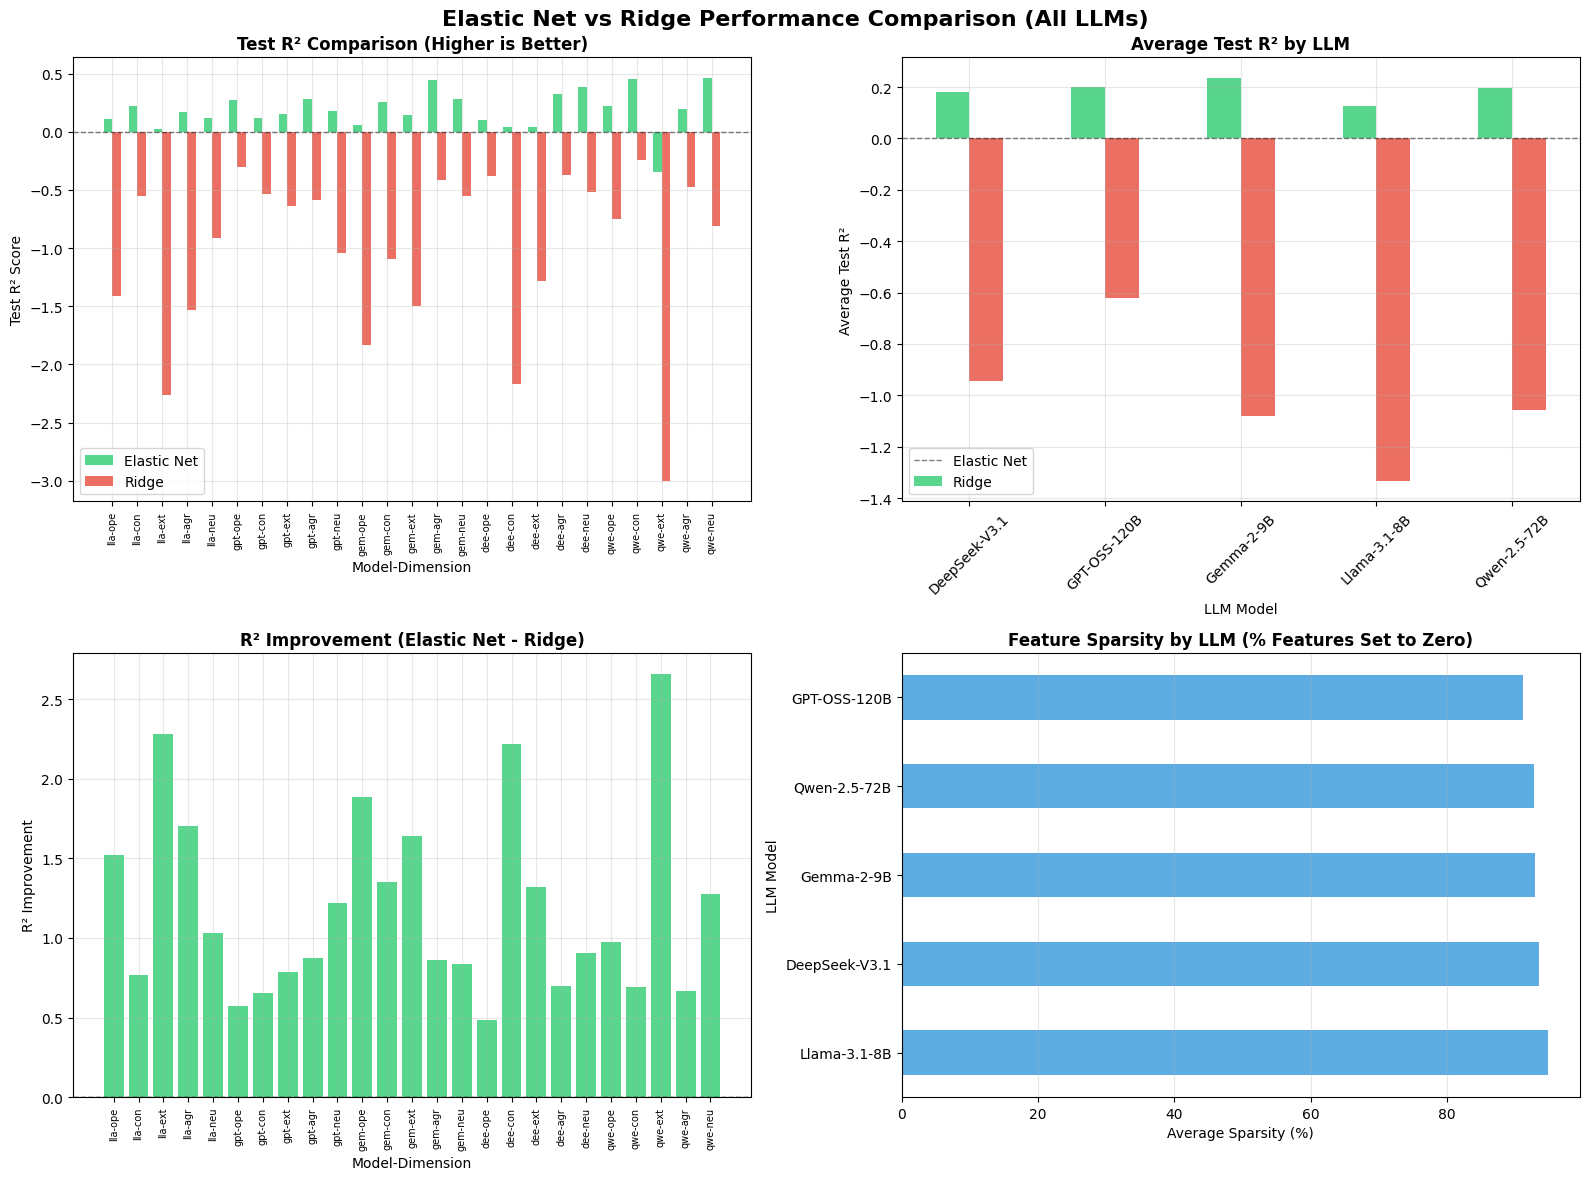

In [6]:
# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Elastic Net vs Ridge Performance Comparison (All LLMs)', fontsize=16, fontweight='bold')

# 1. Test R² Comparison
ax1 = axes[0, 0]
x_pos = np.arange(len(comparison_df))
width = 0.35

ax1.bar(x_pos - width/2, comparison_df['ElasticNet_R2'], width, label='Elastic Net', color='#2ecc71', alpha=0.8)
if comparison_df['Ridge_R2'].notna().any():
    ax1.bar(x_pos + width/2, comparison_df['Ridge_R2'], width, label='Ridge', color='#e74c3c', alpha=0.8)
ax1.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax1.set_xlabel('Model-Dimension', fontsize=10)
ax1.set_ylabel('Test R² Score', fontsize=10)
ax1.set_title('Test R² Comparison (Higher is Better)', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=90, labelsize=7)
ax1.set_xticks(x_pos)
ax1.set_xticklabels([f"{row['llm_key'][:3]}-{row['Dimension'][:3]}" for _, row in comparison_df.iterrows()])

# 2. Average R² by LLM
ax2 = axes[0, 1]
avg_by_llm = comparison_df.groupby('LLM')[['ElasticNet_R2', 'Ridge_R2']].mean()
avg_by_llm.plot(kind='bar', ax=ax2, color=['#2ecc71', '#e74c3c'], alpha=0.8)
ax2.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax2.set_xlabel('LLM Model', fontsize=10)
ax2.set_ylabel('Average Test R²', fontsize=10)
ax2.set_title('Average Test R² by LLM', fontsize=12, fontweight='bold')
ax2.legend(['Elastic Net', 'Ridge'])
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='x', rotation=45)

# 3. R² Improvement (ElasticNet - Ridge)
ax3 = axes[1, 0]
if comparison_df['R2_Improvement'].notna().any():
    colors = ['#2ecc71' if x > 0 else '#e74c3c' for x in comparison_df['R2_Improvement']]
    ax3.bar(x_pos, comparison_df['R2_Improvement'], color=colors, alpha=0.8)
    ax3.axhline(y=0, color='black', linestyle='--', linewidth=1)
    ax3.set_xlabel('Model-Dimension', fontsize=10)
    ax3.set_ylabel('R² Improvement', fontsize=10)
    ax3.set_title('R² Improvement (Elastic Net - Ridge)', fontsize=12, fontweight='bold')
    ax3.grid(True, alpha=0.3)
    ax3.tick_params(axis='x', rotation=90, labelsize=7)
    ax3.set_xticks(x_pos)
    ax3.set_xticklabels([f"{row['llm_key'][:3]}-{row['Dimension'][:3]}" for _, row in comparison_df.iterrows()])
else:
    ax3.text(0.5, 0.5, 'Ridge data not available', ha='center', va='center', transform=ax3.transAxes)

# 4. Sparsity Analysis
ax4 = axes[1, 1]
sparsity_by_llm = comparison_df.groupby('LLM')['Sparsity_%'].mean().sort_values(ascending=False)
sparsity_by_llm.plot(kind='barh', ax=ax4, color='#3498db', alpha=0.8)
ax4.set_xlabel('Average Sparsity (%)', fontsize=10)
ax4.set_ylabel('LLM Model', fontsize=10)
ax4.set_title('Feature Sparsity by LLM (% Features Set to Zero)', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
viz_file = '../05g_elasticnet_comparison.png'
plt.savefig(viz_file, dpi=300, bbox_inches='tight')
print(f"\nVisualization saved: {viz_file}")
plt.show()

## Step 6: Summary Statistics

In [7]:
print("\n" + "="*80)
print("FINAL SUMMARY")
print("="*80)

print("\n1. Overall Performance (Elastic Net):")
print(f"   Average Test R² across all models: {comparison_df['ElasticNet_R2'].mean():.4f}")
print(f"   Best Test R²: {comparison_df['ElasticNet_R2'].max():.4f}")
print(f"   Worst Test R²: {comparison_df['ElasticNet_R2'].min():.4f}")
print(f"   Std Dev: {comparison_df['ElasticNet_R2'].std():.4f}")

if comparison_df['Ridge_R2'].notna().any():
    print("\n2. Comparison with Ridge:")
    print(f"   Average Ridge Test R²: {comparison_df['Ridge_R2'].mean():.4f}")
    print(f"   Average Improvement: {comparison_df['R2_Improvement'].mean():.4f}")
    print(f"   Models improved: {(comparison_df['R2_Improvement'] > 0).sum()}/{len(comparison_df)}")
    print(f"   Best improvement: {comparison_df['R2_Improvement'].max():.4f}")

print("\n3. Feature Selection (Sparsity):")
print(f"   Average sparsity: {comparison_df['Sparsity_%'].mean():.1f}%")
print(f"   Average features retained: {1024 * (1 - comparison_df['Sparsity_%'].mean()/100):.0f}/1024")

print("\n4. Best Performing LLM:")
best_llm = comparison_df.groupby('LLM')['ElasticNet_R2'].mean().idxmax()
best_r2 = comparison_df.groupby('LLM')['ElasticNet_R2'].mean().max()
print(f"   {best_llm}: {best_r2:.4f}")

print("\n5. Best Performing Dimension:")
best_dim = comparison_df.groupby('Dimension')['ElasticNet_R2'].mean().idxmax()
best_dim_r2 = comparison_df.groupby('Dimension')['ElasticNet_R2'].mean().max()
print(f"   {best_dim}: {best_dim_r2:.4f}")

print("\n" + "="*80)
print("Output Files Generated:")
print("="*80)
print("Models:")
for llm_key in LLM_CONFIGS.keys():
    print(f"  - elasticnet_models_{llm_key}.pkl")
print("\nReports:")
for llm_key in LLM_CONFIGS.keys():
    print(f"  - 05g_elasticnet_training_report_{llm_key}.json")
print("\nComparison:")
print(f"  - 05g_ridge_vs_elasticnet.csv")
print(f"  - 05g_elasticnet_comparison.png")

print("\n" + "="*80)
print("05g Complete!")
print("="*80)


FINAL SUMMARY

1. Overall Performance (Elastic Net):
   Average Test R² across all models: 0.1885
   Best Test R²: 0.4669
   Worst Test R²: -0.3465
   Std Dev: 0.1713

2. Comparison with Ridge:
   Average Ridge Test R²: -1.0071
   Average Improvement: 1.1956
   Models improved: 25/25
   Best improvement: 2.6580

3. Feature Selection (Sparsity):
   Average sparsity: 93.0%
   Average features retained: 72/1024

4. Best Performing LLM:
   Gemma-2-9B: 0.2369

5. Best Performing Dimension:
   neuroticism: 0.2876

Output Files Generated:
Models:
  - elasticnet_models_llama.pkl
  - elasticnet_models_gpt.pkl
  - elasticnet_models_gemma.pkl
  - elasticnet_models_deepseek.pkl
  - elasticnet_models_qwen.pkl

Reports:
  - 05g_elasticnet_training_report_llama.json
  - 05g_elasticnet_training_report_gpt.json
  - 05g_elasticnet_training_report_gemma.json
  - 05g_elasticnet_training_report_deepseek.json
  - 05g_elasticnet_training_report_qwen.json

Comparison:
  - 05g_ridge_vs_elasticnet.csv
  - 05g_

## Analysis Notes

**Key Findings to Look For**:

1. **Overfitting Resolution**: 
   - Ridge showed train R² ≈ 0.999, test R² < 0 (severe overfitting)
   - Elastic Net should show: train R² < 0.9, test R² > 0 (better generalization)

2. **Feature Selection**:
   - L1 regularization should eliminate 70-90% of features
   - Remaining features are most predictive for OCEAN traits

3. **Model Interpretability**:
   - Check top-20 features in training reports
   - Do certain embedding dimensions consistently predict certain OCEAN traits?

4. **Next Steps**:
   - If test R² > 0.2: OCEAN features are valuable for credit prediction
   - If test R² < 0: Consider PCA dimensionality reduction or more data collection